# Poisson equation in 2D: joint estimation of the solution and the diffusion 

This is a **jinns** reimplementation of the inverse problem studied in [this article](https://arxiv.org/pdf/2306.08827.pdf) for example, the original code is available [here](https://github.com/i207M/PINNacle/blob/main/src/pde/inverse.py#L58).

Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
-\nabla(a(x,y)\nabla u(x,y)) = f(x, y),\\
f(x,y)=\frac{2\pi^2\sin\pi x\sin\pi y}{1+x^2+y^2+(x-1)^2+(y-1)^2}+
\frac{2\pi((2x-1)\cos\pi x\sin\pi y+(2y-1)\sin\pi x\cos \pi y)}{(1+x^2+y^2+(x-1)^2+(y-1)^2)^2}, \text{ (source term)}.
\end{cases}
$$
On ther boundary $\partial\Omega$ we set
$$
a(x,y) = \frac{1}{1+x^2+y^2+(x-1)^2+(y-1)^2}.
$$

We get that the true solution on $\Omega$ that we will estimate with a PINN is 
$$
u(x,y)=\sin\pi x\sin\pi y.
$$
The ground truth on $\Omega$ of the diffusion coefficient is
$$
a(x,y) = \frac{1}{1+x^2+y^2+(x-1)^2+(y-1)^2}.
$$



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


2024-03-04 11:52:17.360675: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## Observations

We simulate some observations

In [5]:
def u_true(x):
    return jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])
v_u_true = vmap(u_true)

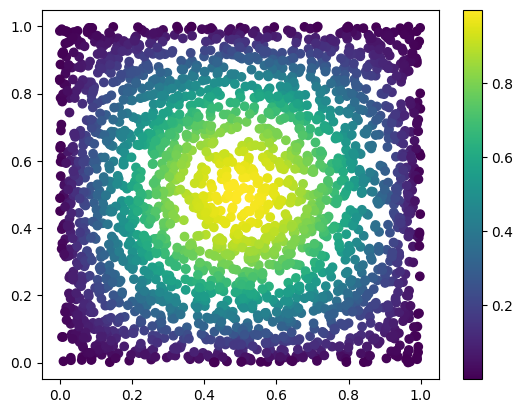

In [6]:
key, subkey = jax.random.split(key)
n_obs = 2500
x = jax.random.uniform(subkey, shape=(n_obs, 2), minval=0.0, maxval=1.0)
obs = v_u_true(x)

obs_batch = jnp.concatenate([
    x[..., 0:1], x[..., 1:2], obs[..., None]
    ], axis=-1)

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


__Optionally blur the observed values__

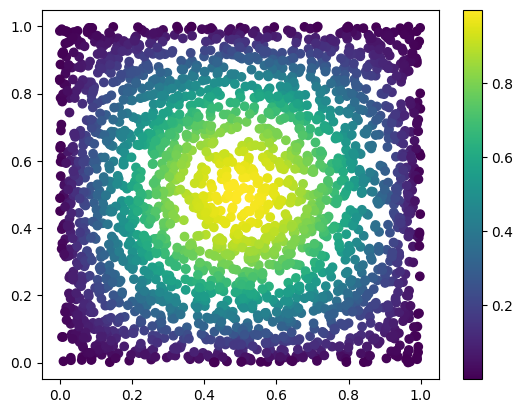

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    0 #random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


Create the neural network architecture for the PINN. The network will have two outputs:

- $u(x,y)$, the classical PINN output
- $a(x, y)$. This secondary PINN output should then be treated as the diffusion coefficient, i.e., an equation parameter. However, in **jinns** equation parameters are fed through the dictionary `params["eq_params"]`. Thus, in order to feed the second PINN output to the dictionnary, one needs to specify a transform using the `eq_params_heterogeneity` argument. We discuss this in more details in below in the loss construction section.

In [8]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 2]
]

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, slice_solution=jnp.s_[:1])
init_nn_params = u.init_params()

In [9]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "a":0. # The second output of the PINN will correspond to the diffusion coefficient, so the value here is irrelevant
    }
}

Create a DataGenerator object

In [10]:
n = 500
nb = 320
omega_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, xmin),
    (xmax, xmax),
    method
)

Create the DataGenerator for observations

In [22]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    omega_batch_size,
    observed_pinn_in=obs_batch[:, 0:2],
    observed_values=obs_batch[:, 2:3]
)

## Loss construction

Create the 2D Poisson loss. The loss contains **heterogeneous parameters** (*i.e.* which depends on $(x,y)$) that can be managed in two steps:

1. Define a dictionary `eq_params_heterogeneity` with any kind of functions that should be applied to the equation parameters. Here, the diffusion parameter (`params["eq_params"]["a"]`) is taken as the second output of the PINN. Thus, we design a custom transform function set to key `"a"` of the `eq_params_heterogeneity` dictionary. Note that whatever the transform, the arguments of such a function must be `x, u, params` in the stationary case.

2. Transform the parameters according to the content of the dictionary `eq_params_heterogeneity` at each call to `evaluate`. This can be done simply by decorating the `evaluate()` method with `@evaluate_heterogeneous_parameters`. The equivalent code of such decorator would be:
```
params["eq_params"] = self.eval_heterogeneous_parameters(
     x, u, params, self.eq_params_heterogeneity)
```

In [23]:
def a_to_pinn_output(x, u, params):
    """
    A jittable function that attributes the second output of u to the diffusion coefficient a
    """
    return lambda x, params: u(x, params)[1]

eq_params_heterogeneity = {"a": a_to_pinn_output} # STEP 1.

In [24]:
from jinns.loss._DynamicLossAbstract import PDEStatio

class PoissonLoss2D(PDEStatio):
    def __init__(self, eq_params_heterogeneity):
        super().__init__(eq_params_heterogeneity=eq_params_heterogeneity)

    @PDEStatio.evaluate_heterogeneous_parameters # STEP 2.
    def evaluate(self, x, u, params):
        # Because of the decoration with evaluate_heterogeneous_parameters the params we receive are 
        #already modified with the user defined eq_params_heterogeneity
        u_pinn = lambda x, params: jnp.squeeze(u(x, params)[u.slice_solution])
        def source_term(xy, params):
            x, y = xy[0], xy[1]
            return (
                (2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)) / (1 + x ** 2 + y ** 2 + (x-1) ** 2 + (y-1)**2)
                + 2 * jnp.pi * (
                    (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
                    + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
                )  / (1 + x ** 2 + y ** 2 + (x-1) ** 2 + (y-1)**2) ** 2
            )
        a_times_jac_u = lambda x, params: params["eq_params"]["a"](x, params) * jax.jacrev(u_pinn, 0)(x, params)
        return jinns.loss._operators._div_rev(None, x, a_times_jac_u, params) + source_term(x, params)

In [25]:
poisson_loss = PoissonLoss2D(
    eq_params_heterogeneity=eq_params_heterogeneity
)

Create the boundary function and the global loss

In [26]:
def a_boundary(dx):
    dx, dy = dx[0], dx[1]
    return 1 / (1 + dx ** 2 + dy ** 2 + (dx - 1) ** 2 + (dy - 1) ** 2)

In [27]:
loss_weights = {"dyn_loss":1, "boundary_loss":10, "observations":10}

loss = jinns.loss.LossPDEStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=poisson_loss,
    omega_boundary_fun=lambda dx: a_boundary(dx),
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1],
)


In [28]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = jinns.data.append_obs_batch(train_data.get_batch(), obs_data.get_batch())
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 609.50
Individual losses: {'boundary_loss': '9.61', 'dyn_loss': '595.25', 'initial_condition': '0.00', 'norm_loss': '0.00', 'observations': '4.64', 'sobolev': '0.00'}


## Joint estimation of `a(x,y)` and `nn_params`

In [29]:
params = init_params


In [30]:
import optax
n_iter = 100000
tx = optax.adamw(learning_rate=5e-4)

Then start optimization

In [31]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=10000,
    obs_data=obs_data
)

Iteration 0: loss value = 749.0132446289062


  0%|          | 0/100000 [00:00<?, ?it/s]

Iteration 10000: loss value = 0.15333771705627441
Iteration 20000: loss value = 0.06981924921274185
Iteration 30000: loss value = 0.06774704158306122
Iteration 40000: loss value = 0.14506548643112183
Iteration 50000: loss value = 0.04203355312347412
Iteration 60000: loss value = 0.03453908488154411
Iteration 70000: loss value = 0.04561769962310791
Iteration 80000: loss value = 0.023543525487184525
Iteration 90000: loss value = 0.03583504259586334
Iteration 100000: loss value = 0.2099144458770752


## Results

Plot the loss values

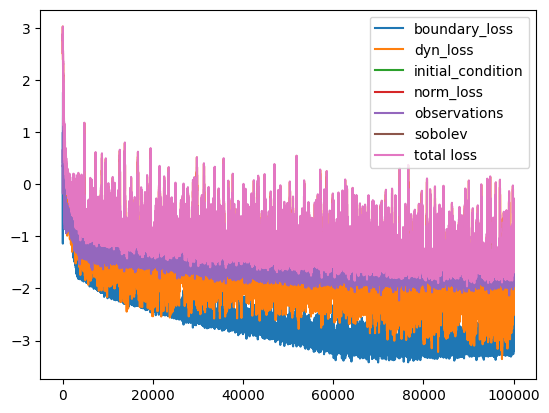

In [33]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solutions learned by the PINN

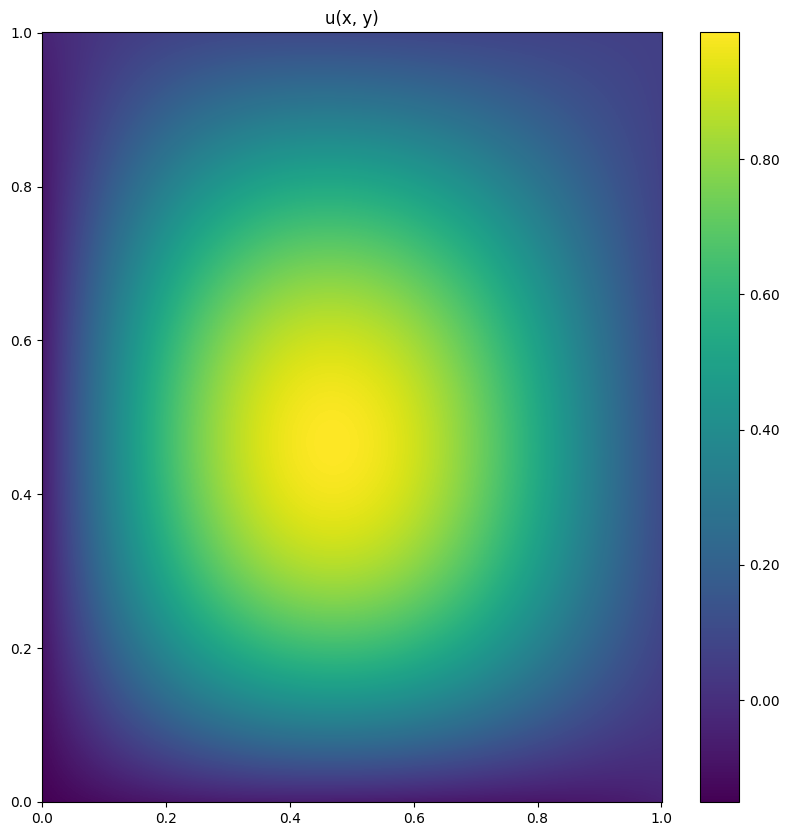

In [34]:
u_est = lambda x: u(x, params)[0]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(u_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="u(x, y)")

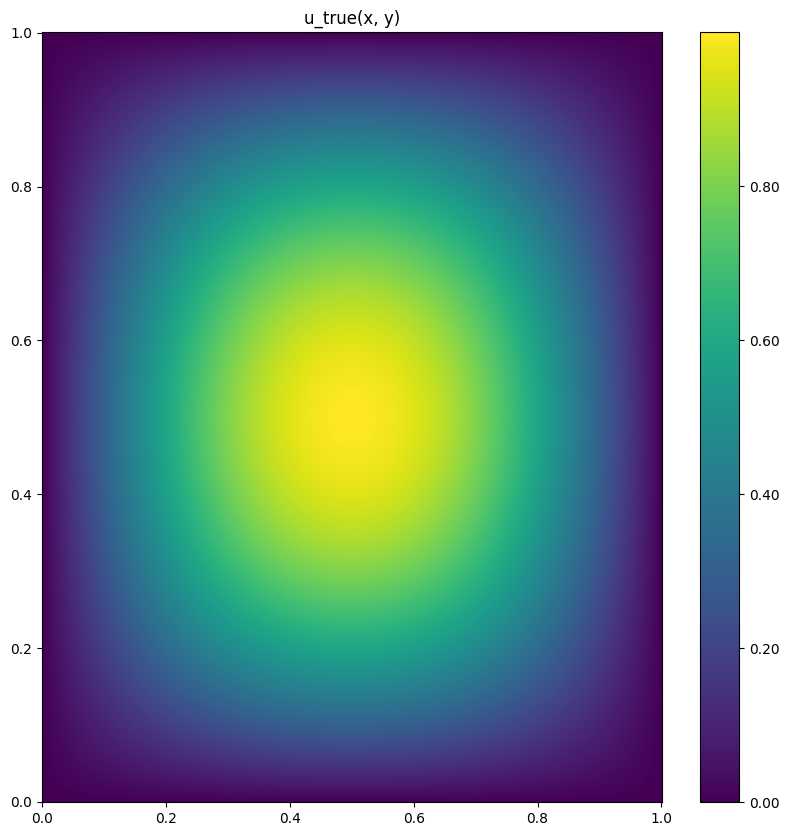

In [35]:
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(u_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="u_true(x, y)")

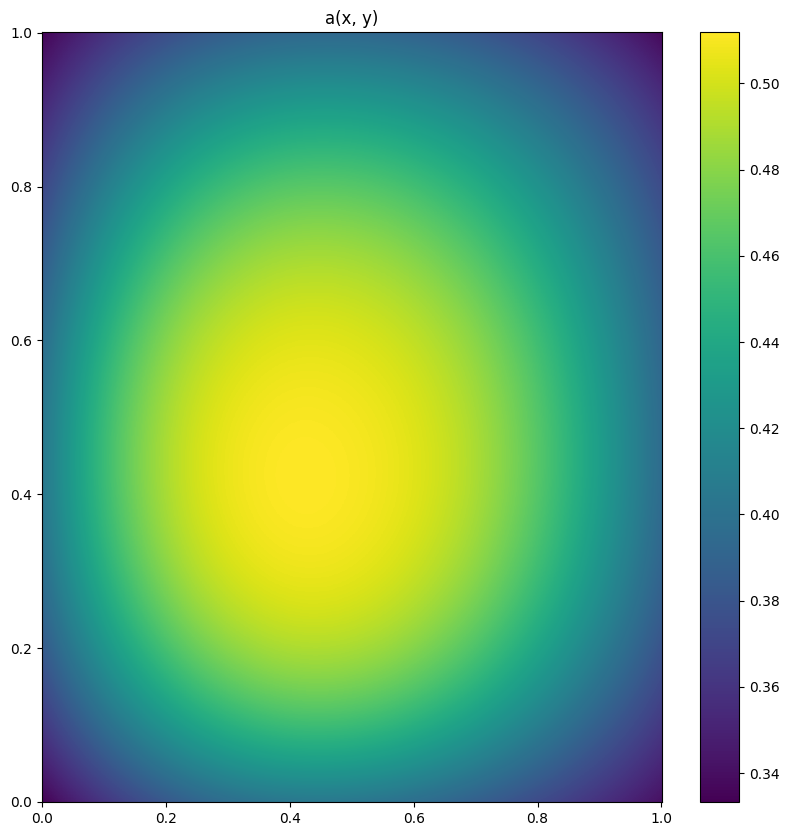

In [36]:
a_est = lambda x: u(x, params)[1]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(a_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="a(x, y)")

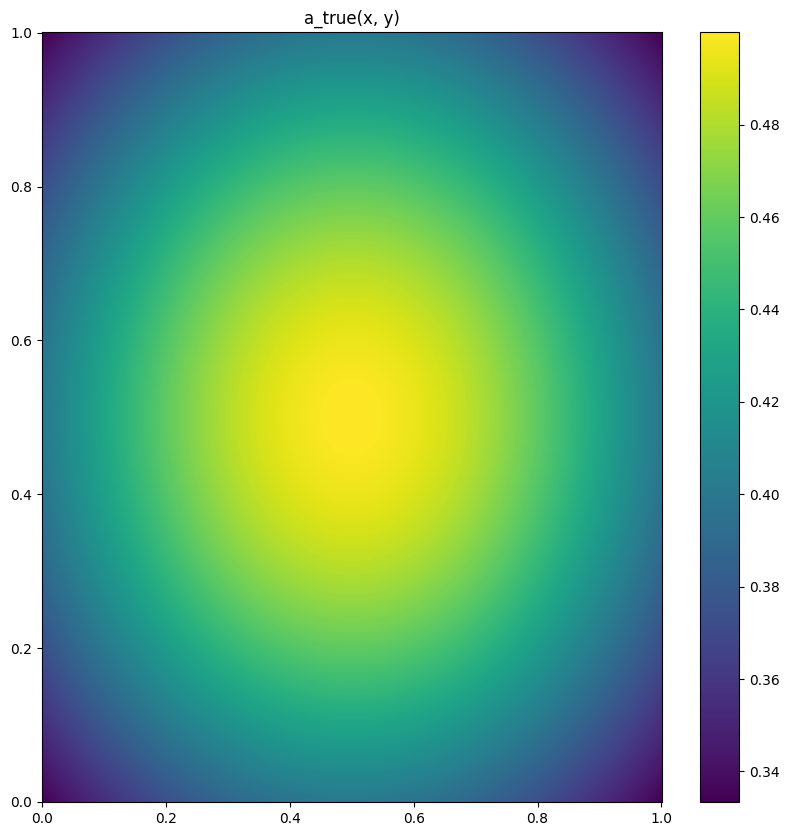

In [37]:
a_true = a_boundary
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(a_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="a_true(x, y)")

## Conclusion

The results have been computed around 4 minutes on a Nvidia T600 GPU (100000/100000 [03:52<00:00, 407.96it/s]). Specific finetuning and longer training would bring more precise results.